<a href="https://colab.research.google.com/github/ggyppsyy/colab_experiments/blob/master/ResolutionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import os 
from tensorflow.keras import utils
import itertools

%matplotlib inline 

In [3]:
nc = 3
image_size = (nc,64,64)
final_size = (nc,128,128)
ndf = 64
ngf = 64
num_D_layers = 6
num_G_layers = 6
num_epochs = 500
batch_size = 96
learning_rate = 1e-3

lambda_identity = 0.5
lambda_A = 10.0
lambda_B = 10.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
reorganize_crops = lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
image_transforms_D = transforms.Compose([transforms.Resize(final_size[1]),
                                       transforms.CenterCrop(final_size[1]),
                                       transforms.ToTensor()])
image_transforms_G = transforms.Compose([transforms.Resize(final_size[1]),
                                         transforms.CenterCrop(final_size[1]),
                                         transforms.Resize(image_size[1]),
                                         transforms.ToTensor()])

import pathlib
data_root_orig = utils.get_file('flower_photos',
                                'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
                                untar=True)
data_root_A = pathlib.Path(data_root_orig)
print(data_root_A)

flower_image_paths = list(data_root_A.glob('*/*'))
flower_image_paths = [str(path) for path in flower_image_paths]
image_count = len(flower_image_paths)
train_dataset_A = ImageFolder(data_root_A,transform=image_transforms_D)
train_dataset_B = ImageFolder(data_root_A,transform=image_transforms_G)


/root/.keras/datasets/flower_photos


In [0]:
train_loader_A = torch.utils.data.DataLoader(dataset=train_dataset_A,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=True)

train_loader_B = torch.utils.data.DataLoader(dataset=train_dataset_B,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=True)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu    
        num_layers = num_D_layers
        num_2step_layers = int(((final_size[1].bit_length() - 1) / 8) * 8) - 2
        num_1step_layers = num_layers - num_2step_layers
        num_1step_layers = 0
        layers = [nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                  nn.LeakyReLU(0.2, inplace=True)]
        l = 1
        print(num_2step_layers)
        while (num_2step_layers>0 or num_1step_layers>0):
            if (num_2step_layers>0):
                layers.append(nn.Conv2d(ndf*2**(l-1), 
                                        ndf*2**l,
                                        4, 2, 1, bias=False))
                layers.append(nn.BatchNorm2d(ndf*2**l))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                num_2step_layers -= 1
                l += 1
            if (num_1step_layers>0):
                layers.append(nn.Conv2d(ndf*2**(l-1), 
                                        ndf*2**(l-1),
                                        3, 1, 1, bias=False))
                layers.append(nn.BatchNorm2d(ndf*2**(l-1)))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                num_1step_layers -= 1        
        layers.append(nn.Conv2d(ndf*2**(l-1), 
                                1, 2, 1, 0, bias=False))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.model, input, range(self.ngpu))
        else:
            output = self.model(input)
        return output.view(-1, 1).squeeze(1)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        num_layers = num_G_layers - 2
        start_size = int(((image_size[1].bit_length() - 1) / 8) * 8)
        finish_size = int(((final_size[1].bit_length() - 1) / 8) * 8)
        num_deconv_layers = finish_size - start_size
        num_1step_layers = num_layers - num_deconv_layers
        print(num_deconv_layers)
        layers = [nn.ConvTranspose2d(nc, ngf*2**(num_deconv_layers), 3, 1, 1, bias=False),
                  nn.BatchNorm2d(ngf*2**(num_deconv_layers)),
                  nn.ReLU(True)]
        l = num_deconv_layers
        while (num_1step_layers>0 or num_deconv_layers>0):
            if (num_1step_layers>0):
                layers.append(nn.Conv2d(ngf*2**(l), 
                                        ngf*2**(l),
                                        3, 1, 1, bias=False))
                layers.append(nn.BatchNorm2d(ngf*2**(l)))
                layers.append(nn.ReLU(True))
                num_1step_layers -= 1    
            if (num_deconv_layers>0):
                layers.append(nn.ConvTranspose2d(ngf*2**l, 
                                                 ngf*2**(l-1),
                                                 4, 2, 1, bias=False))
                layers.append(nn.BatchNorm2d(ngf*2**(l-1)))
                layers.append(nn.ReLU(True))
                l = num_deconv_layers = num_deconv_layers - 1
        layers.append(nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False))
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.model, input, range(self.ngpu))
        else:
            output = self.model(input)
        return output

In [10]:
'''discriminator = Discriminator(1)
discriminator = discriminator.to(device)
discriminator.apply(weights_init)'''

'discriminator = Discriminator(1)\ndiscriminator = discriminator.to(device)\ndiscriminator.apply(weights_init)'

In [11]:
'''generator = Generator(1)
generator = generator.to(device)
generator.apply(weights_init)'''

'generator = Generator(1)\ngenerator = generator.to(device)\ngenerator.apply(weights_init)'

In [0]:
class ResGAN(nn.Module):
    def __init__(self):
        super(ResGAN, self).__init__()
        self.gen = Generator(1).to(device).apply(weights_init)
        self.dis = Discriminator(1).to(device).apply(weights_init)
        self.true_labels = torch.ones([batch_size])-0.1
        self.true_labels = self.true_labels.to(device)
        self.false_labels = torch.zeros([batch_size])
        self.false_labels = self.false_labels.to(device)
        self.lambda_A = 3
        self.lambda_B = 4
        self.GANcrit = nn.BCELoss()
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        self.pool = nn.AvgPool2d(2,stride=2,padding=0)
        
        self.optimizerD = optim.Adam(self.dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.01)
        self.optimizerG = optim.Adam(self.gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    def backward_G(self, real, fake):
        #print(fake.shape)
        #print(real.shape)
        loss_G = self.GANcrit(self.dis(fake), self.true_labels)
        loss_idt = self.criterionIdt(fake, real) * self.lambda_A
        with torch.no_grad():
            shrunk_fake = self.pool(fake)
        rec = self.gen(shrunk_fake)
        #print(rec.shape)
        loss_cycle = self.criterionCycle(fake, rec) * self.lambda_B
        loss = 8 * loss_G + loss_cycle + loss_idt
        loss.backward()
        return loss
    
    def backward_D(self, real, fake):
        #print(fake.shape)
        #print(real.shape)
        pred_real = self.dis(real)
        loss_D_real = self.GANcrit(pred_real, self.true_labels)
        pred_fake = self.dis(fake.detach())
        loss_D_fake = self.GANcrit(pred_fake, self.false_labels)
        # Combined loss and calculate gradients
        loss = (loss_D_real + loss_D_fake) * 0.5
        loss.backward()
        return loss
    
    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    
    def update_params(self, D_input, G_input):
        fake = self.gen(G_input)
        self.set_requires_grad([self.dis], False)
        self.optimizerG.zero_grad()
        G_loss = self.backward_G(D_input, fake)
        self.optimizerG.step()
        self.set_requires_grad([self.dis], True)
        self.optimizerD.zero_grad()
        D_loss = self.backward_D(D_input, fake)
        self.optimizerD.step()
        return G_loss,D_loss
        
    def display_images(self, small,large):
        fake = self.gen(small)
        #im = np.random.randint(self.batch_size_modifier)
        #im = self.batch_size_modifier-1
        
        grid_img = torchvision.utils.make_grid(torch.cat((fake,large), 0), nrow=2).data.cpu().numpy()
        img = np.round_(grid_img.transpose(1, 2, 0) * 254 + 1).astype('uint8')
        display(Image.fromarray(img))

In [13]:
res = ResGAN()
res = res.to(device)

1
5


Epoch [1/500], Step [25/38], Loss G: 99.7078, Loss D: 4.5440


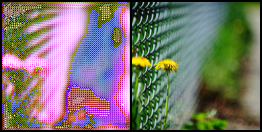

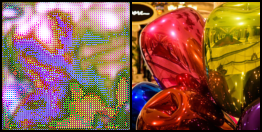

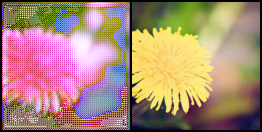

Epoch [2/500], Step [25/38], Loss G: 32.7766, Loss D: 0.7627


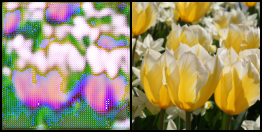

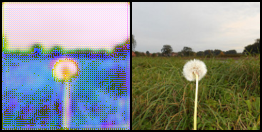

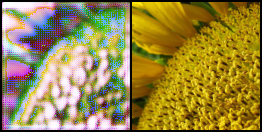

Epoch [3/500], Step [25/38], Loss G: 6.4281, Loss D: 0.9363


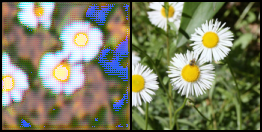

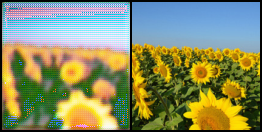

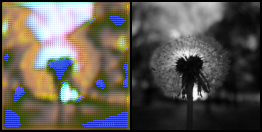

Epoch [4/500], Step [25/38], Loss G: 10.4431, Loss D: 0.5066


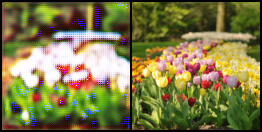

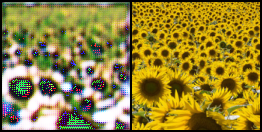

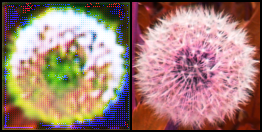

Epoch [5/500], Step [25/38], Loss G: 5.8968, Loss D: 0.7732


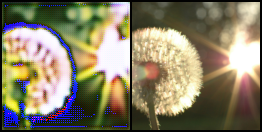

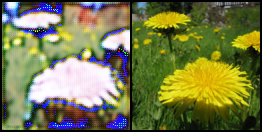

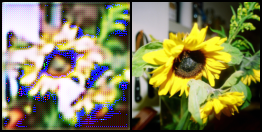

In [0]:
for epoch in range(num_epochs):  
    for i, ((images_A,_),(images_B,_)) in enumerate(zip(train_loader_A,train_loader_B)):
        D_input = Variable(images_A.view(-1,nc,final_size[1],final_size[2])).to(device)
        G_input = Variable(images_B.view(-1,nc,image_size[1],image_size[2])).to(device)
        G_loss,D_loss, = res.update_params(D_input, G_input)
        if (i+1)%25==0:
            print('Epoch [%d/%d], Step [%d/%d], Loss G: %.4f, Loss D: %.4f'
                 %(epoch+1, num_epochs, i+1, image_count//batch_size, G_loss.data,D_loss.data))
    if epoch+1%50==0: num_images=8
    else: num_images=3
    for i in range(num_images):
        index_B = np.random.randint(image_count)
        G_input,_ = train_dataset_B.__getitem__(index_B)
        D_input,_ = train_dataset_A.__getitem__(index_B)
        G_input = Variable(G_input.view(-1,nc,image_size[1],image_size[2])).to(device)
        D_input = Variable(D_input.view(-1,nc,final_size[1],final_size[2])).to(device)
        with torch.no_grad():
            res.display_images(G_input,D_input)
    